In [1359]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn import metrics
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')

In [1360]:
test_data = pd.read_csv("C:/Users/Chungeun Lee/Downloads/open/open/test.csv")
train_data = pd.read_csv("C:/Users/Chungeun Lee/Downloads/open/open/train.csv")

In [1361]:
# Load your data
international_trade = pd.read_csv("C:/Users/Chungeun Lee/Downloads/open/open/international_trade.csv")


# Rename columns and convert 'Period' to datetime
international_trade = international_trade.rename(columns={'기간': 'Period', '품목명': 'item', '수출 중량': 'Export Weight', 
                                                          '수출 금액': 'Export Value', '수입 중량': 'Import Weight', 
                                                          '수입 금액': 'Import Value', '무역수지': 'Trade Balance'})
international_trade['Period'] = pd.to_datetime(international_trade['Period'], format='%Y-%m')

# Sort the data by period and item
international_trade.sort_values(by=['item', 'Period'], inplace=True)
crop_name_to_code = {
    '감귤': 'TG',
    '꽃양배추와 브로콜리(broccoli)': 'BC',
    '당근': 'CR',
    '양배추': 'CB'
}

# Create an empty DataFrame for March 1, 2023
march_2023_data = pd.DataFrame({
    'Period': pd.to_datetime('2023-03-01'),
    'item': crop_name_to_code
})

# Load and preprocess the international trade data
international_trade['item'] = international_trade['item'].replace(crop_name_to_code)
international_trade = international_trade[international_trade['item'].isin(['TG', 'BC', 'CR', 'CB'])]
# Function to create lagged features
def create_lagged_features(df, columns):
    for col in columns:
        df[f'{col}_prev_month'] = df.groupby('item')[col].shift(1)
        df[f'{col}_2_months_prior'] = df.groupby('item')[col].shift(2)
        df['month'] = df['Period'].dt.month
        df['year'] =df['Period'].dt.year
        monthly_avg = df.groupby(['item', 'month'])[col].transform('mean')
        df[f'{col}_monthly_avg'] = monthly_avg
        # Forward-fill zero values before calculating pct_change
        df[col] = df[col].replace(0, np.nan).ffill().fillna(0)
        df[f'{col}_prev_pct_change'] = df.groupby('item')[col].pct_change().shift(1)
        df.replace([np.inf, -np.inf], 0, inplace=True)

    return df

# Columns to create lagged features for
lag_columns = ['Export Weight', 'Import Weight', 'Trade Balance']

# Add empty columns for the features
for col in lag_columns + [f'{col}_monthly_avg' for col in lag_columns] + [f'{col}_prev_pct_change' for col in lag_columns]:
    march_2023_data[col] = np.nan

# Append the empty data for March 2023 to the international_trade dataset
international_trade = pd.concat([international_trade, march_2023_data], ignore_index=True)

# Apply the create_lagged_features function to fill the new rows with appropriate values
international_trade = create_lagged_features(international_trade, lag_columns)

# Handle NaN values as before
international_trade.update(international_trade.filter(like='pct_change').fillna(0))
for col in lag_columns:
    international_trade[f'{col}_prev_month'].fillna(international_trade[f'{col}_monthly_avg'], inplace=True)
    international_trade[f'{col}_2_months_prior'].fillna(international_trade[f'{col}_monthly_avg'], inplace=True)

international_trade.drop(['Export Weight','Export Value','Import Weight','Import Value', 'Trade Balance','Period'],axis =1, inplace =True)

In [1362]:
full_data = pd.concat([train_data, test_data], axis=0)
full_data

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
1087,RD_F_J_20230327,2023-03-27,RD,F,J,NaN,NaN
1088,RD_F_J_20230328,2023-03-28,RD,F,J,NaN,NaN
1089,RD_F_J_20230329,2023-03-29,RD,F,J,NaN,NaN
1090,RD_F_J_20230330,2023-03-30,RD,F,J,NaN,NaN


In [1363]:
full_data['timestamp'] = pd.to_datetime(full_data['timestamp'])
full_data['year'] = full_data['timestamp'].dt.year
full_data['month'] = full_data['timestamp'].dt.month
full_data['day_of_week'] = full_data['timestamp'].dt.dayofweek  # Monday=0, Sunday=6

In [1364]:
import math
start_date = full_data['timestamp'].min()
# Calculate week index
full_data['week_index'] = full_data['timestamp'].apply(
    lambda x: max(math.ceil((x - start_date).days / 7), 0)
)

In [1331]:
# full_data['saturday'] = (full_data['day_of_week'] == 5).astype(int)
# full_data['sunday'] = (full_data['day_of_week'] == 6).astype(int)


In [1365]:
# Add COVID binary variable full_data
def covid_period_indicator(date):
    return 1 if date >= pd.Timestamp('2020-02-01') and date <= pd.Timestamp('2021-12-31') else 0

full_data['covid_period'] = full_data['timestamp'].apply(covid_period_indicator)


In [1366]:
full_datasets = {}
for item in full_data['item'].unique():
    full_datasets[item] = full_data[full_data['item'] == item].copy()

In [1367]:
items = ['TG', 'CR', 'CB', 'RD', 'BC']
start_date = pd.to_datetime('2019-01-04')

# Initialize an empty dictionary to store the processed dataframes
processed_data = {}

# Process each DataFrame
for item in items:
    # Copy the dataframe
    data_item = full_datasets[item].copy()

    # Group by timestamp and calculate mean
    data_item = data_item.groupby('timestamp')[['supply(kg)', 'price(원/kg)']].mean().reset_index()

    # Convert timestamp to datetime
    data_item['timestamp'] = pd.to_datetime(data_item['timestamp'])

    # Calculate week index
    data_item['week_index'] = data_item['timestamp'].apply(
        lambda x: max(math.ceil((x - start_date).days / 7), 0)
    )

    # Store the processed dataframe
    processed_data[item] = data_item

# Access the processed DataFrames
data_TG = processed_data['TG']
data_CR = processed_data['CR']
data_CB = processed_data['CB']
data_RD = processed_data['RD']
data_BC = processed_data['BC']


In [1368]:
def add_date_features(df):
    df = df.reset_index()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day_of_week'] = df['timestamp'].dt.dayofweek  # Monday=0, Sunday=6
    return df

# Apply the function to each DataFrame
data_TG = add_date_features(data_TG)
data_BC = add_date_features(data_BC)
data_CB = add_date_features(data_CB)
data_CR = add_date_features(data_CR)
data_RD = add_date_features(data_RD)


In [1369]:
for item in items:
    data_item = globals()[f'data_{item}']
    data_item.rename(columns={'supply(kg)': 'supply', 'price(원/kg)': 'price'}, inplace=True)


In [1337]:
# def calculate_cumulative_monthly_average_ignore_year(df, column_name):
#     # Group by month only and calculate cumulative sum and count
#     df['month'] = df['timestamp'].dt.month
#     cumsum = df.groupby('month')[column_name].cumsum() - df[column_name]
#     cumcount = df.groupby('month').cumcount()

#     # Calculate cumulative average, avoiding division by zero
#     df[f'month_avg_{column_name}'] = cumsum / cumcount.replace(0, np.nan)

#     return df

# # Apply the function to each DataFrame
# for item in items:
#     data_item = globals()[f'data_{item}']
#     data_item = calculate_cumulative_monthly_average_ignore_year(data_item, 'supply')
#     data_item = calculate_cumulative_monthly_average_ignore_year(data_item, 'price')


In [1370]:
def calculate_rolling_monthly_stats_ignore_year(df, column_name):
    # Convert 'timestamp' to datetime if not already
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Extract month
    df['month'] = df['timestamp'].dt.month

    # Initialize columns for rolling stats
    df[f'30d_mean_{column_name}'] = np.nan
    df[f'30d_max_{column_name}'] = np.nan
    df[f'30d_min_{column_name}'] = np.nan

    # Calculate rolling stats for each month, considering all previous values
    for month, group in df.groupby('month'):
        rolling_stats = group[column_name].expanding(min_periods=1).agg(['mean', 'max', 'min'])
        
        # Update the original DataFrame
        idx = group.index
        df.loc[idx, f'30d_mean_{column_name}'] = rolling_stats['mean']
        df.loc[idx, f'30d_max_{column_name}'] = rolling_stats['max']
        df.loc[idx, f'30d_min_{column_name}'] = rolling_stats['min']
    
    return df

# Apply the function to each DataFrame
for item in items:
    data_item = globals()[f'data_{item}']
    data_item = calculate_rolling_monthly_stats_ignore_year(data_item, 'supply')
    data_item = calculate_rolling_monthly_stats_ignore_year(data_item, 'price')


In [1339]:
# def calculate_rolling_monthly_stats(df, column_name):
#     # Convert 'timestamp' to datetime and set it as index
#     df['timestamp'] = pd.to_datetime(df['timestamp'])
#     df.set_index('timestamp', inplace=True)

#     # Calculate year_month for grouping
#     df['year_month'] = df.index.to_period('M')

#     df[f'30d_mean_{column_name}'] = np.nan
#     df[f'30d_max_{column_name}'] = np.nan
#     df[f'30d_min_{column_name}'] = np.nan

#     for year_month, group in df.groupby('year_month'):
#         # Calculate rolling statistics for the past 30 days
#         rolling_stats = group[column_name].rolling(window='30D', min_periods=1).agg(['mean', 'max', 'min'])

#         # Assign the results back to the main DataFrame
#         idx = group.index
#         df.loc[idx, f'30d_mean_{column_name}'] = rolling_stats['mean']
#         df.loc[idx, f'30d_max_{column_name}'] = rolling_stats['max']
#         df.loc[idx, f'30d_min_{column_name}'] = rolling_stats['min']

#     df.drop('year_month', axis=1, inplace=True)

#     # Reset index if necessary
#     df.reset_index(inplace=True)

#     return df

# # Apply the function to each DataFrame
# for item in items:
#     data_item = globals()[f'data_{item}']
#     data_item = calculate_rolling_monthly_stats(data_item, 'supply')
#     data_item = calculate_rolling_monthly_stats(data_item, 'price')


In [1371]:
def calculate_rolling_monthly_weekday_stats_ignore_year(df, column_name):
    # Convert 'timestamp' to datetime if not already
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Extract month and day of the week
    df['month'] = df['timestamp'].dt.month
    df['day_of_week'] = df['timestamp'].dt.dayofweek

    # Initialize columns for rolling stats
    df[f'30d_mean_{column_name}'] = np.nan
    df[f'30d_max_{column_name}'] = np.nan
    df[f'30d_min_{column_name}'] = np.nan

    # Calculate rolling stats for each (month, day_of_week) combination
    for (month, day_of_week), group in df.groupby(['month', 'day_of_week']):
        rolling_stats = group[column_name].rolling(window=30, min_periods=1).agg(['mean', 'max', 'min'])
        
        # Update the original DataFrame
        idx = group.index
        df.loc[idx, f'30d_mean_{column_name}'] = rolling_stats['mean']
        df.loc[idx, f'30d_max_{column_name}'] = rolling_stats['max']
        df.loc[idx, f'30d_min_{column_name}'] = rolling_stats['min']

    return df

# Apply the function to each DataFrame
for item in items:
    data_item = globals()[f'data_{item}']
    data_item = calculate_rolling_monthly_weekday_stats_ignore_year(data_item, 'supply')
    data_item = calculate_rolling_monthly_weekday_stats_ignore_year(data_item, 'price')


In [1341]:
# import pandas as pd
# import numpy as np

# for item in items:
#     data_item = globals()[f'data_{item}']

#     #1. Expanding Window Statistics
#     data_item['expanding_mean_price'] = data_item['price'].expanding().mean()
#     data_item['expanding_min_price'] = data_item['price'].expanding().min()
#     data_item['expanding_max_price'] = data_item['price'].expanding().max()
#     data_item['expanding_std_price'] = data_item['price'].expanding().std()

#     # 2. Rolling Window Statistics (example: 12-week window)
#     data_item['rolling_mean_price_12w'] = data_item['price'].rolling(window=12).mean()
#     data_item['rolling_std_price_12w'] = data_item['price'].rolling(window=12).std()

#     # Create a temporary dataset
#     temp_data_item = data_item.copy()
#     # Replace 0s with NaNs in the 'price' column
#     temp_data_item['price'] = temp_data_item['price'].replace(0, np.nan)

    # # Forward fill the NaNs
    # temp_data_item['price'] = temp_data_item['price'].fillna(method='ffill')
    # temp_data_item['price'] = temp_data_item['price'].fillna(method='bfill')
    # # Calculate price change
    # temp_data_item['price_change'] = temp_data_item['price'].pct_change()

    # # Add the price_change column back to the original dataframe
    # data_item['price_change'] = temp_data_item['price_change']
    # # 3. Rate of Change Features
    # data_item['price_change_4w'] = data_item['price'].pct_change(periods=4)
#    # 1. Expanding Window Statistics
#     data_item['expanding_mean_supply'] = data_item['supply'].expanding().mean()
#     data_item['expanding_min_supply'] = data_item['supply'].expanding().min()
#     data_item['expanding_max_supply'] = data_item['supply'].expanding().max()
#     data_item['expanding_std_supply'] = data_item['supply'].expanding().std()

#     # 2. Rolling Window Statistics (example: 12-week window)
#     data_item['rolling_mean_supply_12w'] = data_item['supply'].rolling(window=12).mean()
#     data_item['rolling_std_supply_12w'] = data_item['supply'].rolling(window=12).std()

    # # Replace 0s with NaNs in the 'supply' column
    # temp_data_item['supply'] = temp_data_item['supply'].replace(0, np.nan)

    # # Forward fill the NaNs
    # temp_data_item['supply'] = temp_data_item['supply'].fillna(method='ffill')
    # temp_data_item['supply'] = temp_data_item['supply'].fillna(method='bfill')

    # # Calculate supply change
    # temp_data_item['supply_change'] = temp_data_item['supply'].pct_change()

    # # Add the supply_change column back to the original dataframe
    # data_item['supply_change'] = temp_data_item['supply_change']
    # # 3. Rate of Change Features
    # data_item['supply_change_4w'] = data_item['supply'].pct_change(periods=4)

    # # 7. Fourier Features for Seasonality
    # for k in range(1, 4):  # Using first 3 sine and cosine terms
    #     data_item[f'sin_week_{k}'] = np.sin(2 * np.pi * k * data_item['week_index'] / 52)
    #     data_item[f'cos_week_{k}'] = np.cos(2 * np.pi * k * data_item['week_index'] / 52)

    # # Handle NaN values that may have been introduced by these transformations
    # data_item.fillna(method='bfill', inplace=True)  # Backfill NaN values
    # data_item.fillna(method='ffill', inplace=True)  # Forward fill if there are still NaNs


In [1372]:
for item in items:
    data_item = globals()[f'data_{item}']
    # Calculate week index average price and supply
    data_item['week_index_avg_price'] = data_item.groupby('week_index')['price'].transform('mean')
    data_item['week_index_avg_supply'] = data_item.groupby('week_index')['supply'].transform('mean')
    # Create lagged features by shifting 28 periods
    data_item['lagged_week_index_avg_price_1'] = data_item['week_index_avg_price'].shift(28)
    data_item['lagged_week_index_avg_supply_1'] = data_item['week_index_avg_supply'].shift(28)
    data_item['lagged_week_index_avg_price_2'] = data_item['week_index_avg_price'].shift(35)
    data_item['lagged_week_index_avg_supply_2'] = data_item['week_index_avg_supply'].shift(35)
    data_item['lagged_week_index_avg_price_3'] = data_item['week_index_avg_price'].shift(42)
    data_item['lagged_week_index_avg_supply_3'] = data_item['week_index_avg_supply'].shift(42)
    data_item['lagged_week_index_avg_price_4'] = data_item['week_index_avg_price'].shift(49)
    data_item['lagged_week_index_avg_supply_4'] = data_item['week_index_avg_supply'].shift(49)

    data_item.drop(['week_index_avg_price', 'week_index_avg_supply','index','timestamp','supply','price','week_index','year','month','month','day_of_week'], axis=1, inplace=True)

In [1373]:
data_TG

,30d_mean_supply,30d_max_supply,30d_min_supply,30d_mean_price,30d_max_price,30d_min_price,lagged_week_index_avg_price_1,lagged_week_index_avg_supply_1,lagged_week_index_avg_price_2,lagged_week_index_avg_supply_2,lagged_week_index_avg_price_3,lagged_week_index_avg_supply_3,lagged_week_index_avg_price_4,lagged_week_index_avg_supply_4
0,0.000000,0.00,0.00,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.00,0.00,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,88437.640000,88437.64,88437.64,1944.000000,1944.0,1944.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67933.550000,67933.55,67933.55,1706.700000,1706.7,1706.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,68098.540000,68098.54,68098.54,1644.800000,1644.8,1644.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,10796.681667,19223.40,4597.90,3961.416667,6026.4,2002.8,2843.728571,14415.332857,2722.314286,15954.43,1982.7,19715.564286,1931.985714,22276.151429
1547,8084.665158,18421.92,2614.50,3761.810526,5348.6,2017.3,2843.728571,14415.332857,2722.314286,15954.43,1982.7,19715.564286,1931.985714,22276.151429
1548,8488.272105,15369.67,3560.60,3937.942105,5360.1,2666.3,2843.728571,14415.332857,2722.314286,15954.43,1982.7,19715.564286,1931.985714,22276.151429
1549,8207.115556,16747.70,2944.30,3861.805556,5592.0,2361.4,2843.728571,14415.332857,2722.314286,15954.43,1982.7,19715.564286,1931.985714,22276.151429


In [1374]:
data_TG_expanded = pd.concat([data_TG] * 10, ignore_index=True)
data_BC_expanded = pd.concat([data_BC] * 9, ignore_index=True)
data_RD_expanded = pd.concat([data_RD] * 8, ignore_index=True)
data_CR_expanded = pd.concat([data_CR] * 7, ignore_index=True)
data_CB_expanded = pd.concat([data_CB] * 5, ignore_index=True)

In [1375]:
full_datasets['TG']

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day_of_week,week_index,covid_period
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,0,0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,1,0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,1,0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,1,0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
275,TG_E_S_20230327,2023-03-27,TG,E,S,NaN,NaN,2023,3,0,221,0
276,TG_E_S_20230328,2023-03-28,TG,E,S,NaN,NaN,2023,3,1,221,0
277,TG_E_S_20230329,2023-03-29,TG,E,S,NaN,NaN,2023,3,2,222,0
278,TG_E_S_20230330,2023-03-30,TG,E,S,NaN,NaN,2023,3,3,222,0


In [1376]:
# Example using reset_index
for item in items:
    original_data = full_datasets[item].reset_index(drop=True)
    expanded_data = globals()[f'data_{item}_expanded'].reset_index(drop=True)
    full_datasets[item] = pd.concat([original_data, expanded_data], axis=1)


In [1377]:
# Iterate over each key in the dictionary and apply the filter
for item in items:
    full_datasets[item] = full_datasets[item][full_datasets[item]['week_index'] > 4]

In [1378]:
full_datasets['TG']

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day_of_week,...,30d_max_price,30d_min_price,lagged_week_index_avg_price_1,lagged_week_index_avg_supply_1,lagged_week_index_avg_price_2,lagged_week_index_avg_supply_2,lagged_week_index_avg_price_3,lagged_week_index_avg_supply_3,lagged_week_index_avg_price_4,lagged_week_index_avg_supply_4
29,TG_A_J_20190130,2019-01-30,TG,A,J,27852.0,2377.0,2019,1,2,...,2056.5,0.0,912.675000,39092.797500,NaN,NaN,NaN,NaN,NaN,NaN
30,TG_A_J_20190131,2019-01-31,TG,A,J,15997.0,2278.0,2019,1,3,...,2028.8,1618.0,912.675000,39092.797500,NaN,NaN,NaN,NaN,NaN,NaN
31,TG_A_J_20190201,2019-02-01,TG,A,J,36010.0,2349.0,2019,2,4,...,2030.7,2030.7,912.675000,39092.797500,NaN,NaN,NaN,NaN,NaN,NaN
32,TG_A_J_20190202,2019-02-02,TG,A,J,8808.0,2286.0,2019,2,5,...,2143.4,2143.4,1391.557143,52342.304286,NaN,NaN,NaN,NaN,NaN,NaN
33,TG_A_J_20190203,2019-02-03,TG,A,J,0.0,0.0,2019,2,6,...,0.0,0.0,1391.557143,52342.304286,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15505,TG_E_S_20230327,2023-03-27,TG,E,S,NaN,NaN,2023,3,0,...,6026.4,2002.8,2843.728571,14415.332857,2722.314286,15954.43,1982.7,19715.564286,1931.985714,22276.151429
15506,TG_E_S_20230328,2023-03-28,TG,E,S,NaN,NaN,2023,3,1,...,5348.6,2017.3,2843.728571,14415.332857,2722.314286,15954.43,1982.7,19715.564286,1931.985714,22276.151429
15507,TG_E_S_20230329,2023-03-29,TG,E,S,NaN,NaN,2023,3,2,...,5360.1,2666.3,2843.728571,14415.332857,2722.314286,15954.43,1982.7,19715.564286,1931.985714,22276.151429
15508,TG_E_S_20230330,2023-03-30,TG,E,S,NaN,NaN,2023,3,3,...,5592.0,2361.4,2843.728571,14415.332857,2722.314286,15954.43,1982.7,19715.564286,1931.985714,22276.151429


In [1349]:
# # List of items in international_trade data
# items_in_trade_data = international_trade['item'].unique()

# # Iterate through your full_datasets and merge if item is in international_trade
# for item, dataset in full_datasets.items():
#     if item in items_in_trade_data:
#         # Merge with international trade data
#         dataset = pd.merge(dataset, international_trade, on=['year', 'month', 'item'], how='left')
#         full_datasets[item] = dataset

In [1379]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Initialize dictionaries to store train and test sets
train = {}
test = {}

# Iterate over each key in the dictionary and apply the transformations
for item in items:
    # One-Hot Encoding of categorical variables
    corporation_location_encoded = encoder.fit_transform(full_datasets[item][['corporation', 'location']])
    encoded_cols = encoder.get_feature_names_out(['corporation', 'location'])

    # Adding encoded columns using .loc
    full_datasets[item].loc[:, encoded_cols] = corporation_location_encoded

    # Dropping original categorical columns
    full_datasets[item].drop(['corporation', 'location'], axis=1, inplace=True)

    # Splitting into train and test datasets
    trainset = full_datasets[item][full_datasets[item]['price(원/kg)'].notna()]
    testset = full_datasets[item][full_datasets[item]['price(원/kg)'].isna()]

    # Dropping price(원/kg) and supply(kg) columns from test dataset
    testset.drop(['price(원/kg)', 'supply(kg)'], axis=1, inplace=True)

    # Save the split datasets into the train and test dictionaries
    train[item] = trainset
    test[item] = testset


In [1380]:
train['TG'].dtypes

ID                                        object
timestamp                         datetime64[ns]
item                                      object
supply(kg)                               float64
price(원/kg)                              float64
year                                       int64
month                                      int64
day_of_week                                int64
week_index                                 int64
covid_period                               int64
30d_mean_supply                          float64
30d_max_supply                           float64
30d_min_supply                           float64
30d_mean_price                           float64
30d_max_price                            float64
30d_min_price                            float64
lagged_week_index_avg_price_1            float64
lagged_week_index_avg_supply_1           float64
lagged_week_index_avg_price_2            float64
lagged_week_index_avg_supply_2           float64
lagged_week_index_av

In [1381]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

def walk_forward_validation(data, n_test, params):
    """
    Perform walk-forward validation on the dataset for one item.
    
    :param data: DataFrame containing the data for the item.
    :param n_test: Number of observations to be used for testing.
    :param params: Parameters for the XGBoost model.
    :return: List of validation scores.
    """
    predictions = []
    history = data.iloc[:-n_test, :]
    
    # Walk-forward validation
    for i in range(n_test):
        # Split data into train and validation
        train = history
        test = data.iloc[len(history), :]
        history = history.append(test)
        
        # Separate into features and target
        train_X, train_y = train.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), train['price(원/kg)']
        test_X, test_y = test.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp']), test['price(원/kg)']
        
        # Train the model
        model = xgb.XGBRegressor(**params)
        model.fit(train_X, train_y)
        
        # Make a one-step prediction
        yhat = model.predict(np.array([test_X]))
        predictions.append(yhat[0])
    
    # Calculate validation score
    score = mean_squared_error(data['price(원/kg)'].iloc[-n_test:], predictions, squared=False)
    return score


In [1353]:
# # Your existing walk_forward_validation function remains the same

# # XGBoost parameters
# xgboost_params = {
#     'objective': 'reg:squarederror',
#     'max_depth': 5,
#     'learning_rate': 0.1,
#     'n_estimators': 100,
#     'min_child_weight': 1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'seed': 42
# }

# n_test = 365  # Number of observations to be used for testing

# # Initialize dictionaries to store validation scores and models
# validation_scores = {}
# models = {}

# for item in items:
#     data_item = train[item]
#     score = walk_forward_validation(data_item, n_test, xgboost_params)
#     validation_scores[item] = score
#     print(f'Validation score for {item}: {score}')

#     # Train the final model on the entire training dataset
#     train_X, train_y = data_item.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), data_item['price(원/kg)']
#     final_model = xgb.XGBRegressor(**xgboost_params)
#     final_model.fit(train_X, train_y)

#     # Store the final model
#     models[item] = final_model


In [1382]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# XGBoost parameters
xgboost_params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

models_fixed_window = {}

# Training and validation dates
train_end = '2022-02-28'
val_start = '2022-03-01'
val_end = '2022-03-31'

for item in items:
    data_item = train[item]
    train_set = data_item[(data_item['timestamp'] <= train_end)]
    val_set = data_item[(data_item['timestamp'] >= val_start) & (data_item['timestamp'] <= val_end)]

    X_train, y_train = train_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), train_set['price(원/kg)']
    X_val, y_val = val_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), val_set['price(원/kg)']

    model = xgb.XGBRegressor(**xgboost_params)
    model.fit(X_train, y_train)

    val_predictions = model.predict(X_val)
    val_score = mean_squared_error(y_val, val_predictions, squared=False)
    print(f'Validation score for {item}: {val_score}')

    models_fixed_window[item] = model


Validation score for TG: 1657.0989221587442
Validation score for CR: 341.7357436898666
Validation score for CB: 442.15107019992917
Validation score for RD: 166.99319564723157
Validation score for BC: 795.584366197334


In [1383]:
models_fixed_window1={}    

# After completing the rolling window validation, retrain on the entire dataset
for item in items:
    data_item = train[item]
    # Convert necessary parameters to integers
    X_full, y_full = data_item.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), data_item['price(원/kg)']
    model_final = xgb.XGBRegressor(**xgboost_params)
    model_final.fit(X_full, y_full)

    # Store the final model
    models_fixed_window1[item] = model_final

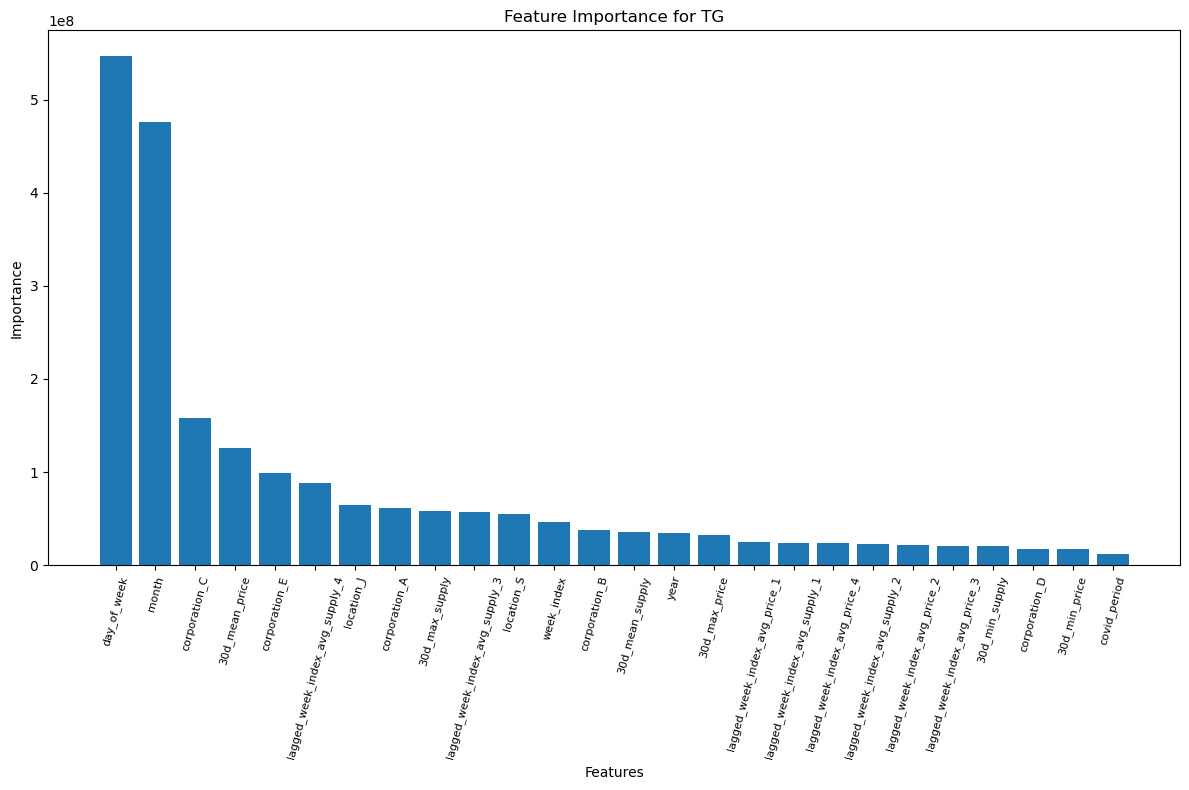

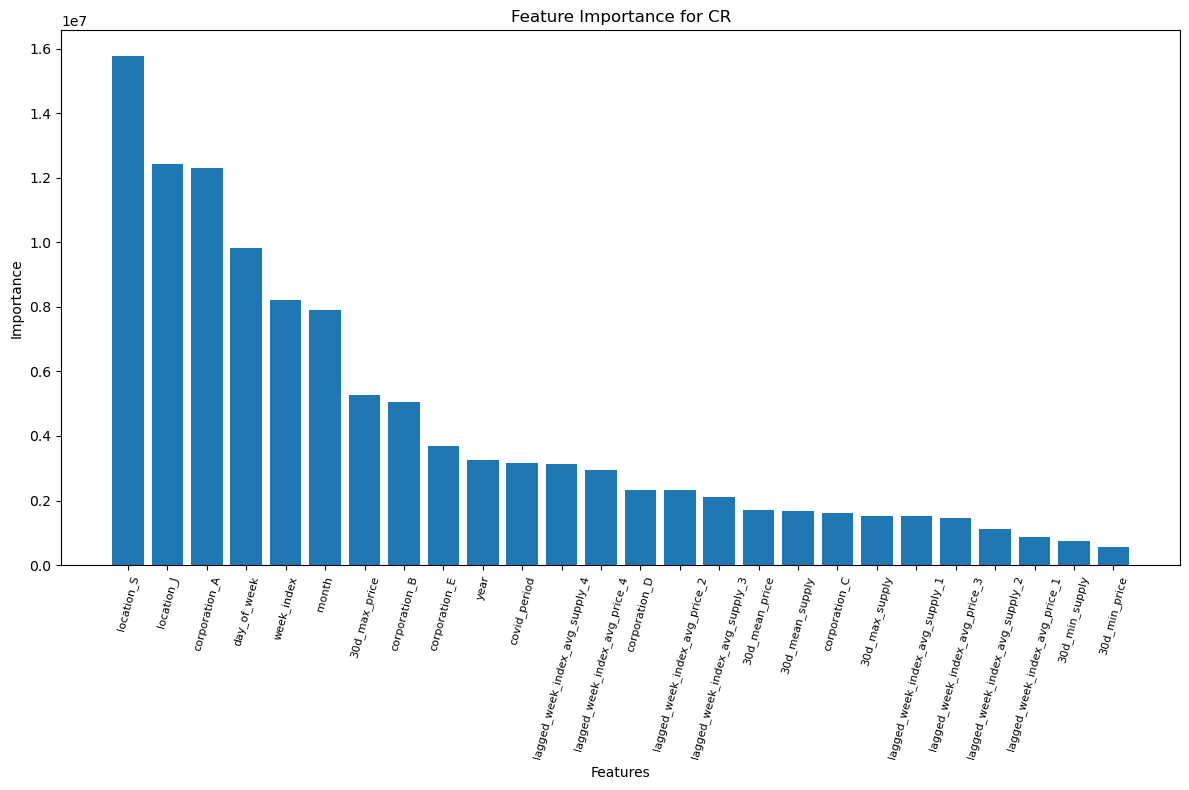

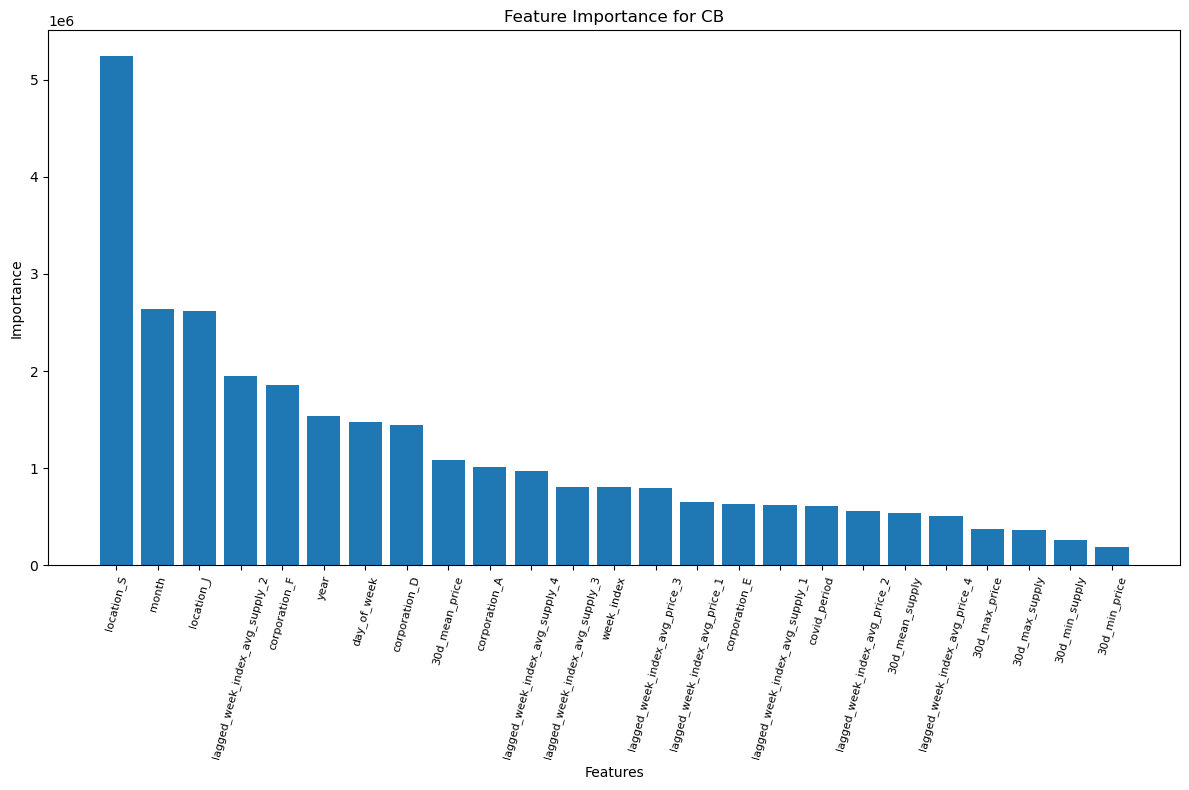

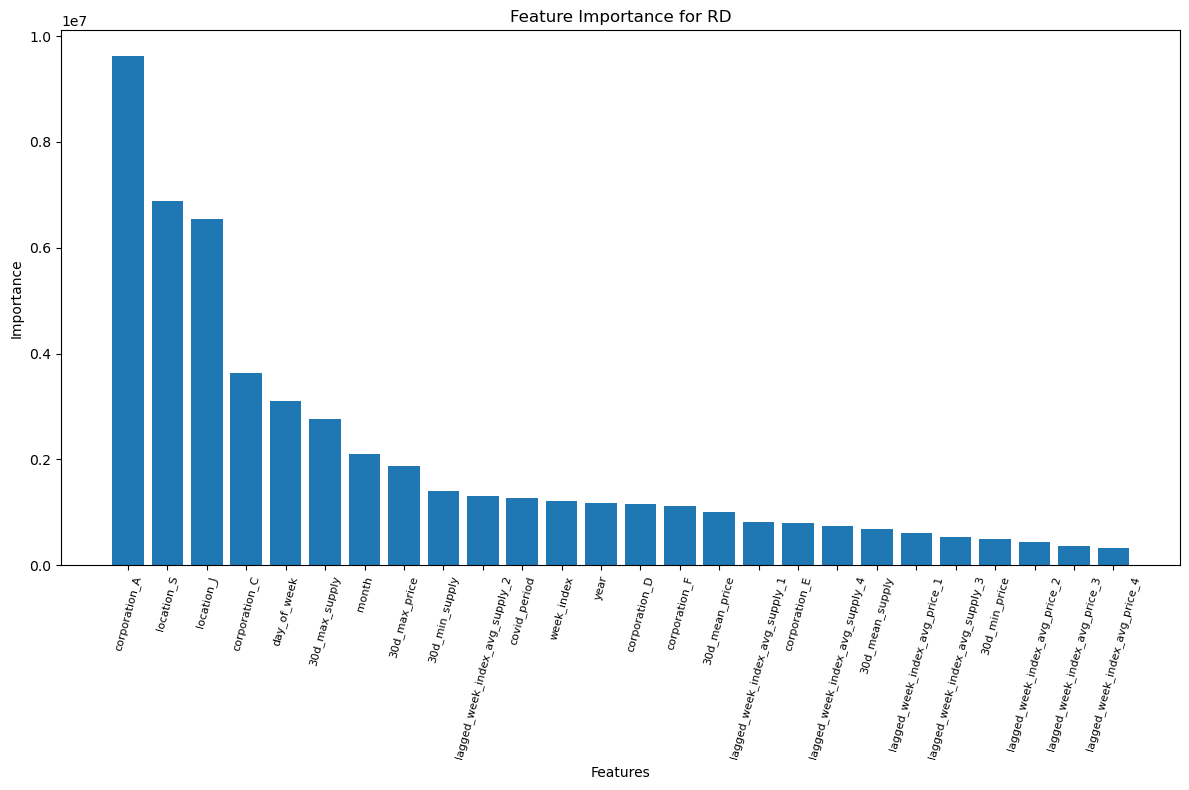

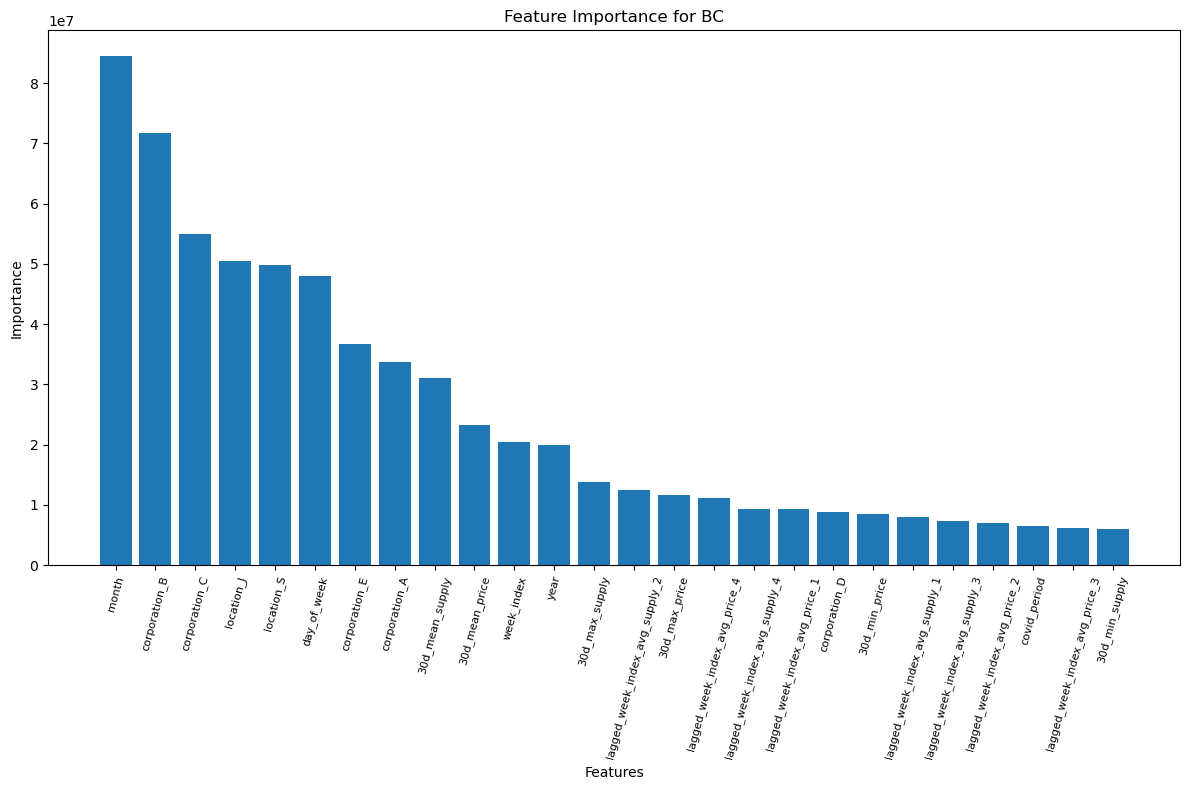

In [1384]:
import matplotlib.pyplot as plt

# Function to plot feature importance
def plot_feature_importance(model, title):
    # Get feature importance
    importance = model.get_booster().get_score(importance_type='gain')
    
    # Sort features by importance
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    
    # Plot
    plt.figure(figsize=(12, 8))  # Increased figure size
    plt.bar(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
    plt.xticks(range(len(sorted_importance)), [val[0] for val in sorted_importance], rotation=75, fontsize=8)  # Adjusted rotation and font size
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(title)
    plt.tight_layout()  # Adjust layout
    plt.show()

# Plot feature importance for each model
for item, model in models_fixed_window1.items():
    plot_feature_importance(model, f'Feature Importance for {item}')


In [1385]:
zero_id_patterns = ['CR_D_S', 'CB_A_S', 'BC_B_S', 'BC_C_S', 'CR_E_S', 'RD_C_S']
import numpy as np
import pandas as pd

# Initialize a dictionary to store predictions
test_predictions = {}

# Loop through each item and its corresponding model
for item, model in models_fixed_window1.items():
    # Prepare the test data (drop irrelevant columns)
    X_test = test[item].drop(['ID', 'timestamp', 'item'], axis=1)
    
    # Make predictions
    predictions = model.predict(X_test)

    # Set negative predictions to zero and limit minimum prediction to 100
    predictions = np.where(predictions < 100, 0, predictions)

    # Correctly reference the test dataframe to filter IDs for zero-setting
    test_ids = test[item]['ID']
    zero_mask = np.full(len(predictions), False)
    for pattern in zero_id_patterns:
        zero_mask |= test_ids.str.contains(pattern)

    predictions[zero_mask] = 0

    # Store predictions in the dictionary
    test_predictions[item] = predictions

# Load the sample submission file
sample_sub = pd.read_csv("C:/Users/Chungeun Lee/Downloads/open/open/sample_submission.csv")

# Loop through each item and update the sample_sub file with predictions
for item, preds in test_predictions.items():
    # Extract the 'ID' column from the test dataset for the current item
    test_ids = test[item]['ID']

    # Update the sample_sub file
    for idx, prediction in zip(test_ids, preds):
        sample_sub.loc[sample_sub['ID'] == idx, 'answer'] = prediction

# Save the updated submission file
sample_sub.to_csv('C:/Users/Chungeun Lee/Desktop/공부/공모전/제주도/submission_fixed1.csv', index=False)


In [1355]:
# March에 대해서만 사용
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd

def rolling_window_evaluation(params, train_data, item, train_start, train_end):
    # Convert integer parameters
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])

    scores = []
    data_item = train_data[item]

    # Loop over each year
    for year in range(2019, 2023):  # Assuming data is available up to 2022
        # Set the training and validation period
        current_train_end = pd.to_datetime(f'{year}-02-28')
        val_start = pd.to_datetime(f'{year}-03-01')
        val_end = pd.to_datetime(f'{year}-03-31')

        train_set = data_item[(data_item['timestamp'] >= train_start) & (data_item['timestamp'] <= current_train_end)]
        val_set = data_item[(data_item['timestamp'] >= val_start) & (data_item['timestamp'] <= val_end)]

        X_train, y_train = train_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), train_set['price(원/kg)']
        X_val, y_val = val_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), val_set['price(원/kg)']

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)
        val_predictions = model.predict(X_val)
        val_score = mean_squared_error(y_val, val_predictions, squared=False)
        scores.append(val_score)

    return -np.mean(scores)  # Negative score for minimization

# Define bounds of hyperparameters
pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 1000),
    'gamma': (0, 5),
    'min_child_weight': (0, 10),
    'max_delta_step': (0, 5),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

# Dictionary to store the best parameters for each item
best_params_per_item = {}

for item in items:
    # Initialize Bayesian Optimization for each item
    optimizer = BayesianOptimization(
        f=lambda **params: rolling_window_evaluation(params, train, item, '2019-01-01', '2020-02-29'),
        pbounds=pbounds,
        random_state=1
    )

    # Start optimization for each item
    optimizer.maximize(init_points=5, n_iter=25)

    # Store the best parameters for each item
    best_params_per_item[item] = optimizer.max

# Print the best parameters for each item
for item, params in best_params_per_item.items():
    print(f"Best parameters for {item}: {params['params']}")


|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -2.194e+0 | 0.7085    | 3.602     | 0.01003   | 1.512     | 4.027     | 0.9234    | 226.9     | 0.6728    |
| 2         | -2.186e+0 | 0.6984    | 2.694     | 0.1316    | 3.426     | 4.431     | 8.781     | 76.02     | 0.8352    |
| 3         | -2.19e+03 | 0.7087    | 2.793     | 0.05071   | 0.9905    | 8.605     | 9.683     | 347.8     | 0.8462    |
| 4         | -2.195e+0 | 0.9382    | 4.473     | 0.03466   | 0.1953    | 4.189     | 8.781     | 143.4     | 0.7106    |
| 5         | -2.188e+0 | 0.9789    | 2.666     | 0.2106    | 1.578     | 7.806     | 8.346     | 67.37     | 0.8751    |
| 6         | -2.188e+0 | 0.5873    | 3.657     | 0.1558    | 2.297     | 5.379     | 9.789     | 75.83     | 0.9501    |
| 7         | -2.192e+0 

In [1356]:
models_rolling_window2={}    

# After completing the rolling window validation, retrain on the entire dataset
for item in items:
    data_item = train[item]
    best_params = best_params_per_item[item]['params']
    # Convert necessary parameters to integers
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['n_estimators'] = int(best_params['n_estimators'])
    X_full, y_full = data_item.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), data_item['price(원/kg)']
    model_final = xgb.XGBRegressor(**best_params)
    model_final.fit(X_full, y_full)

    # Store the final model
    models_rolling_window2[item] = model_final

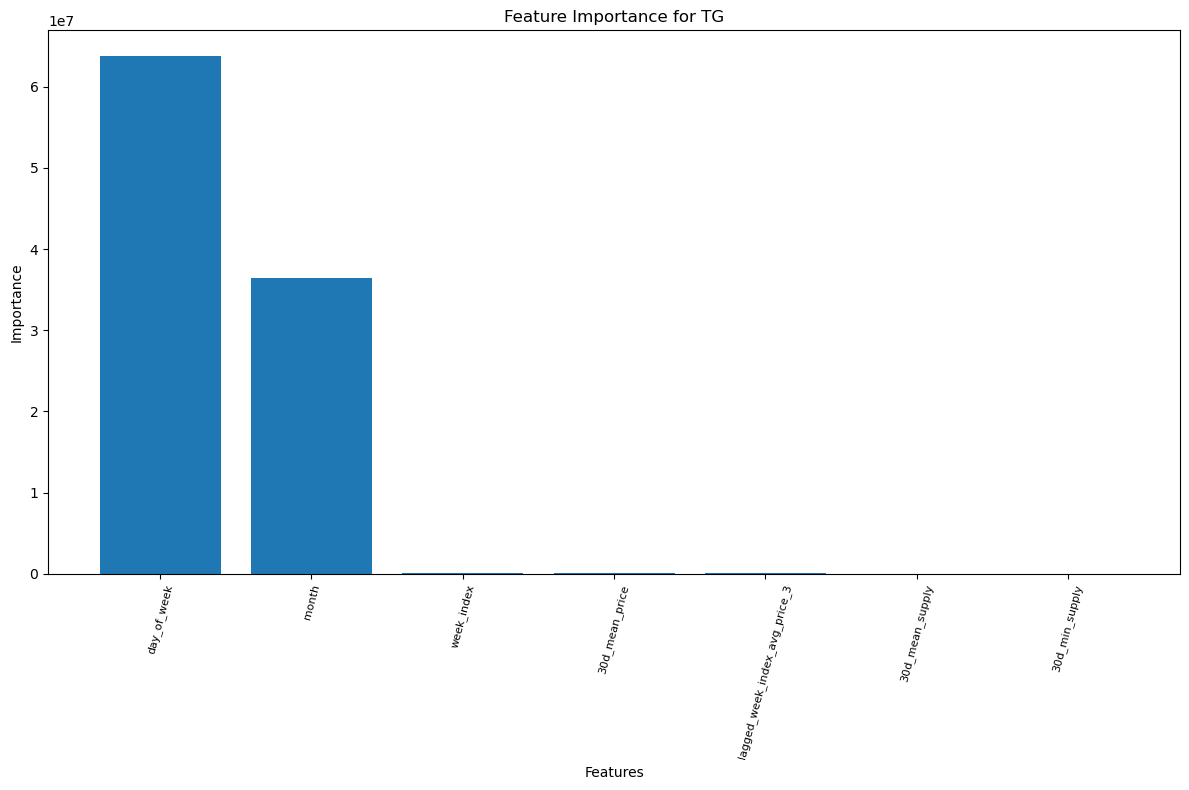

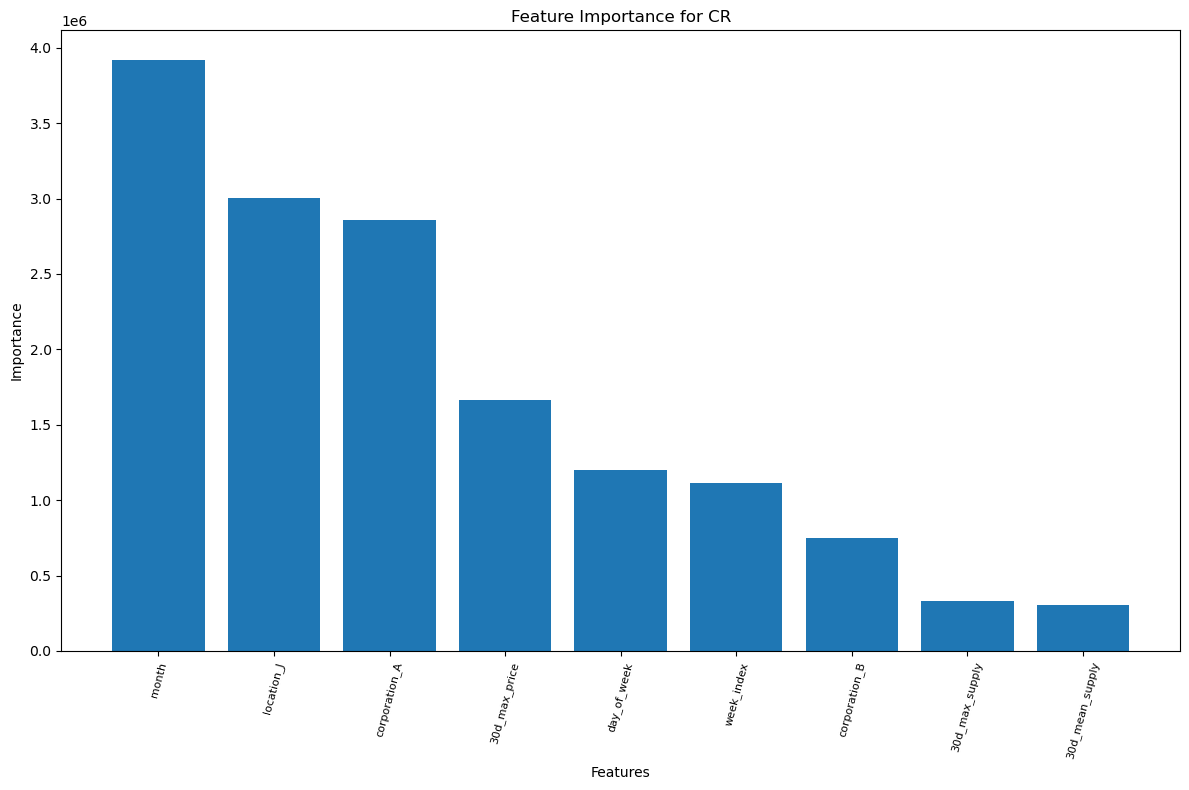

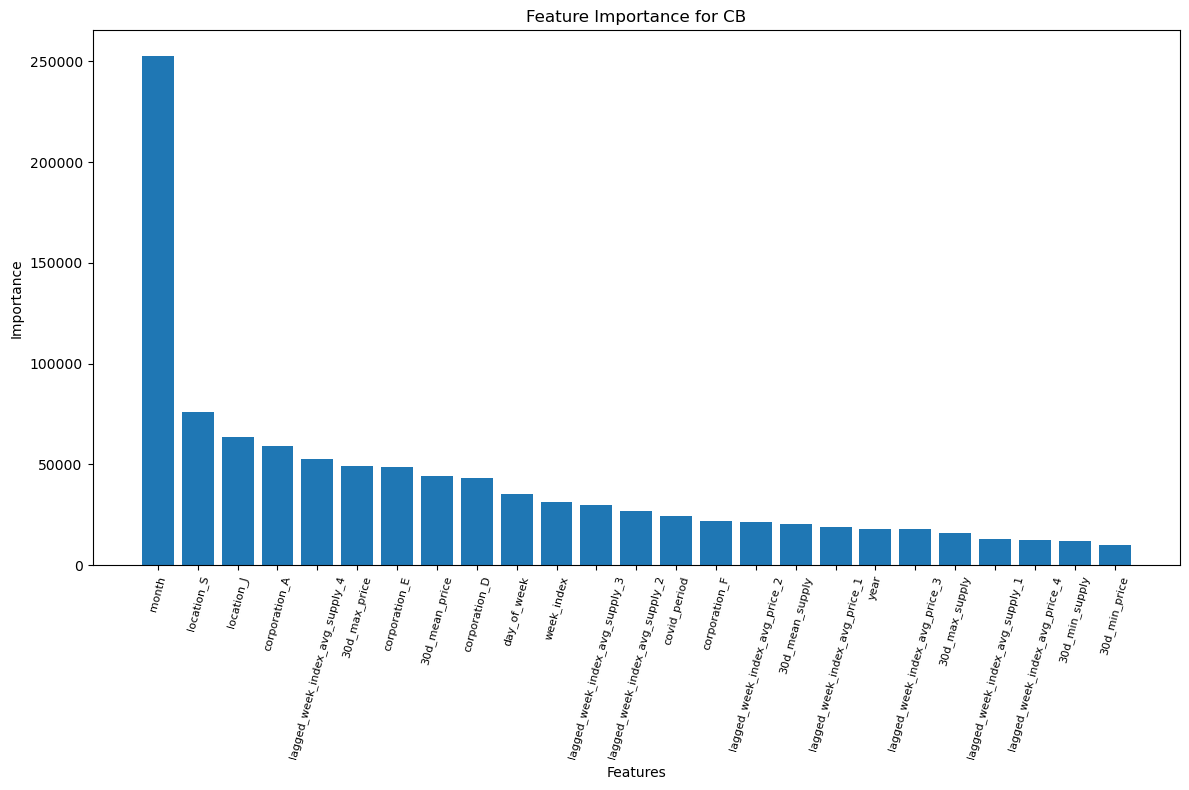

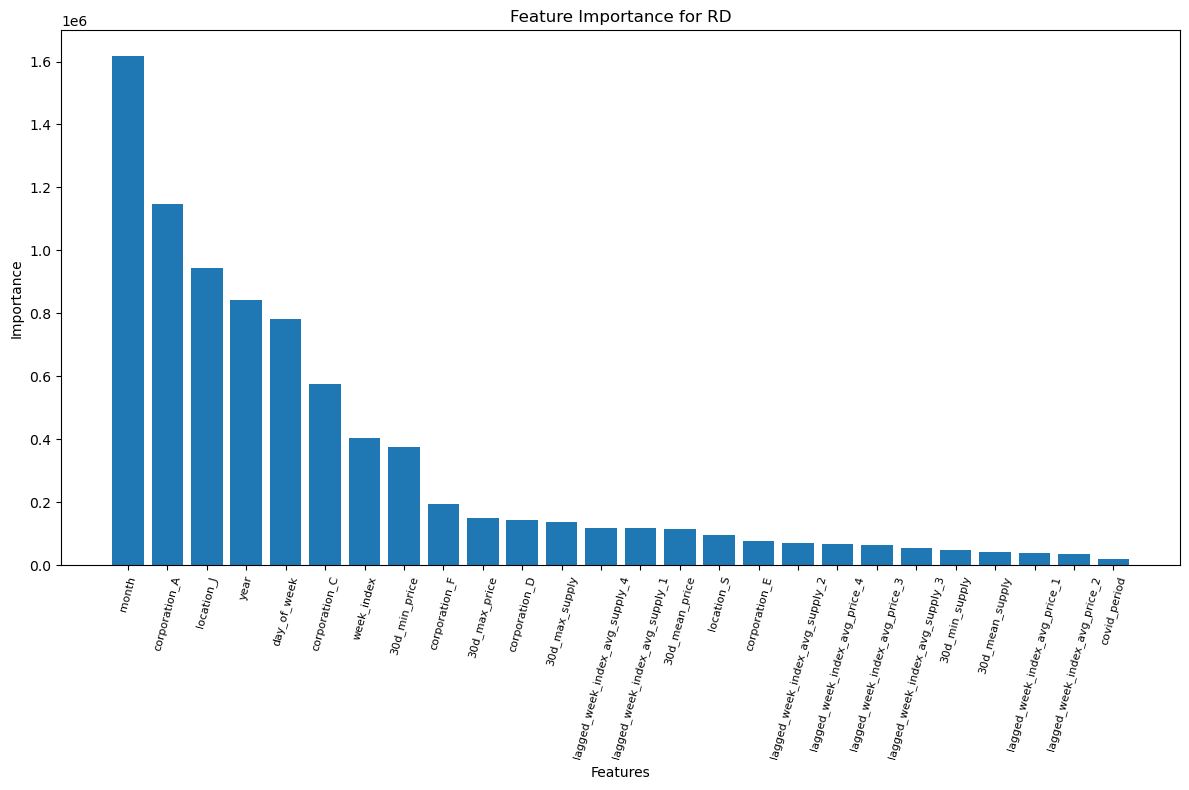

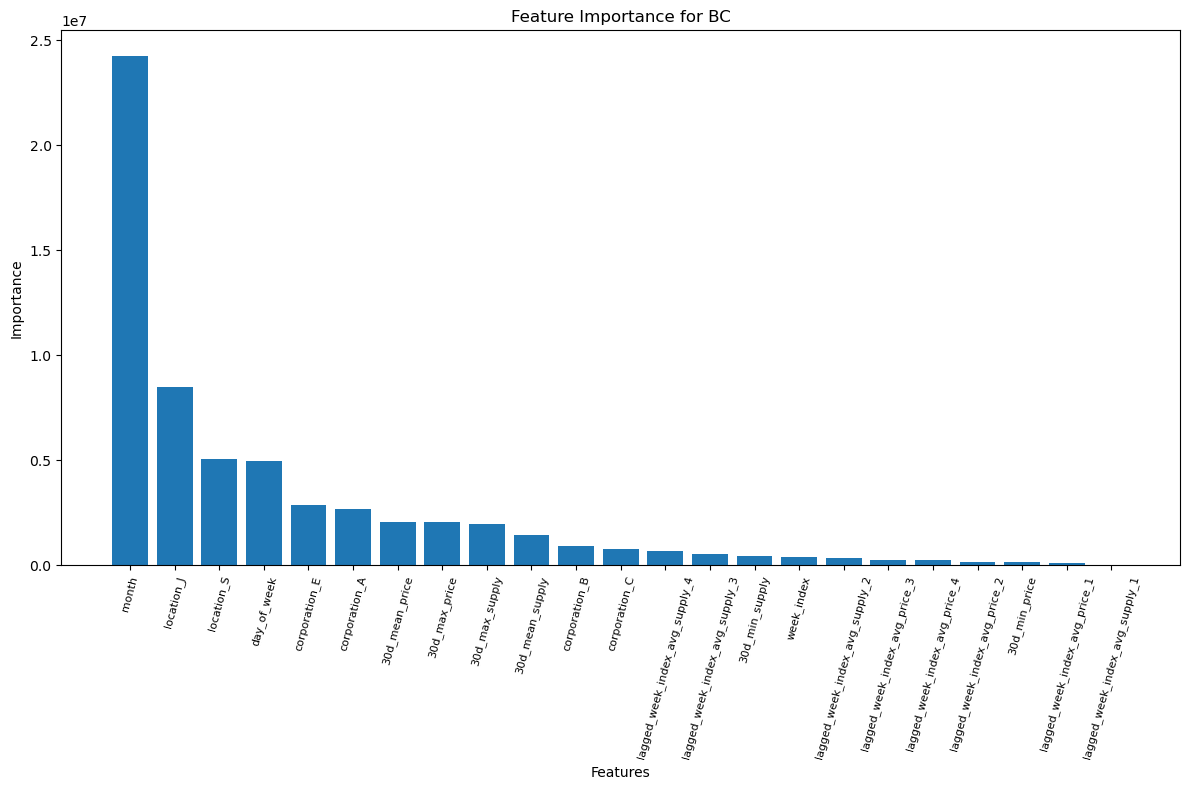

In [1357]:
import matplotlib.pyplot as plt

# Function to plot feature importance
def plot_feature_importance(model, title):
    # Get feature importance
    importance = model.get_booster().get_score(importance_type='gain')
    
    # Sort features by importance
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    
    # Plot
    plt.figure(figsize=(12, 8))  # Increased figure size
    plt.bar(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
    plt.xticks(range(len(sorted_importance)), [val[0] for val in sorted_importance], rotation=75, fontsize=8)  # Adjusted rotation and font size
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(title)
    plt.tight_layout()  # Adjust layout
    plt.show()

# Plot feature importance for each model
for item, model in models_rolling_window2.items():
    plot_feature_importance(model, f'Feature Importance for {item}')


In [1358]:
zero_id_patterns = ['CR_D_S', 'CB_A_S', 'BC_B_S', 'BC_C_S', 'CR_E_S', 'RD_C_S']
import numpy as np
import pandas as pd

# Initialize a dictionary to store predictions
test_predictions = {}

# Loop through each item and its corresponding model
for item, model in models_rolling_window2.items():
    # Prepare the test data (drop irrelevant columns)
    X_test = test[item].drop(['ID', 'timestamp', 'item'], axis=1)
    
    # Make predictions
    predictions = model.predict(X_test)

    # Set negative predictions to zero and limit minimum prediction to 100
    predictions = np.where(predictions < 100, 0, predictions)

    # Correctly reference the test dataframe to filter IDs for zero-setting
    test_ids = test[item]['ID']
    zero_mask = np.full(len(predictions), False)
    for pattern in zero_id_patterns:
        zero_mask |= test_ids.str.contains(pattern)

    predictions[zero_mask] = 0

    # Store predictions in the dictionary
    test_predictions[item] = predictions

# Load the sample submission file
sample_sub = pd.read_csv("C:/Users/Chungeun Lee/Downloads/open/open/sample_submission.csv")

# Loop through each item and update the sample_sub file with predictions
for item, preds in test_predictions.items():
    # Extract the 'ID' column from the test dataset for the current item
    test_ids = test[item]['ID']

    # Update the sample_sub file
    for idx, prediction in zip(test_ids, preds):
        sample_sub.loc[sample_sub['ID'] == idx, 'answer'] = prediction

# Save the updated submission file
sample_sub.to_csv('C:/Users/Chungeun Lee/Desktop/공부/공모전/제주도/bayesian_optimization_submission_v1star.csv', index=False)


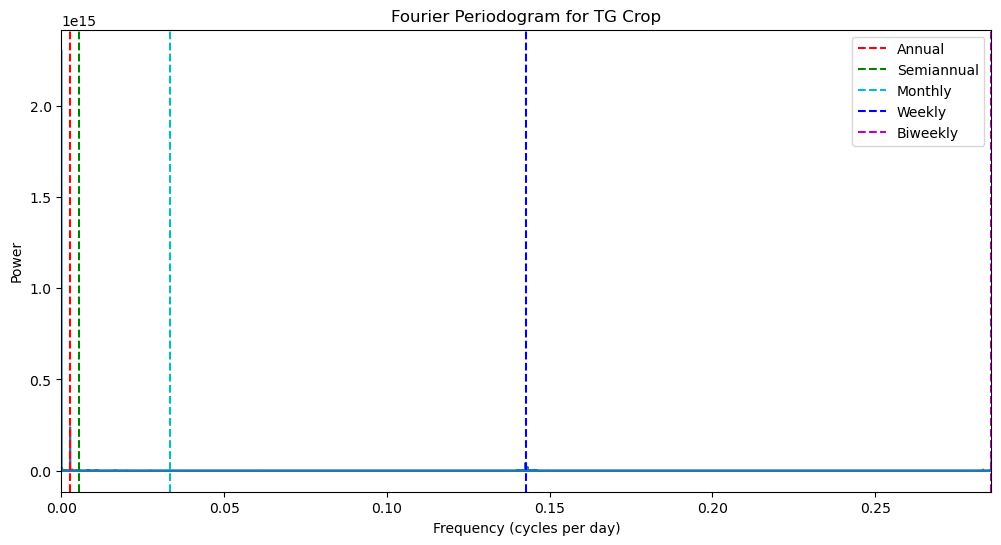

array([2.30100798e+15, 1.52849147e+13, 4.64678166e+11, ...,
       3.91044469e+12, 4.64678166e+11, 1.52849147e+13])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract the time series for the 'TG' crop
time_series = train['TG']['price(원/kg)'].fillna(method='ffill')

# Apply FFT
fft_result = np.fft.fft(time_series)
frequencies = np.fft.fftfreq(len(fft_result), d=1)  # d=1 for daily data

# Compute power spectrum
power_spectrum = np.abs(fft_result)**2

# Plot periodogram
plt.figure(figsize=(12, 6))
plt.plot(frequencies, power_spectrum)
plt.title('Fourier Periodogram for TG Crop')
plt.xlabel('Frequency (cycles per day)')
plt.ylabel('Power')

# Focus on specific frequencies
plt.xlim(0, 2/7)  # Limit to show up to biweekly frequency
plt.axvline(1/365, color='r', linestyle='--', label='Annual')
plt.axvline(2/365, color='g', linestyle='--', label='Semiannual')
plt.axvline(1/30, color='c', linestyle='--', label='Monthly')
plt.axvline(1/7, color='b', linestyle='--', label='Weekly')
plt.axvline(2/7, color='m', linestyle='--', label='Biweekly')
plt.legend()

plt.show()

In [ ]:
from bayes_opt import BayesianOptimization

def rolling_window_evaluation(params, train_data, item, train_start, train_end):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    data_item = train_data[item]
    current_train_end = pd.to_datetime(train_end)
    scores = []

    while current_train_end <= pd.to_datetime('2023-03-02'):
        train_set = data_item[(data_item['timestamp'] >= train_start) & (data_item['timestamp'] <= current_train_end)]
        next_month = (current_train_end + pd.DateOffset(months=1)).strftime('%Y-%m-%d')
        val_set = data_item[(data_item['timestamp'] > current_train_end) & (data_item['timestamp'] <= next_month)]

        X_train, y_train = train_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), train_set['price(원/kg)']
        X_val, y_val = val_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), val_set['price(원/kg)']

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)

        if current_train_end.month == 2 and current_train_end.day == 28:
            val_predictions = model.predict(X_val)
            val_score = mean_squared_error(y_val, val_predictions, squared=False)
            scores.append(val_score)

        current_train_end = pd.to_datetime(next_month)

    if scores:
        return -np.mean(scores)
    else:
        return float('inf')

best_params_per_item = {}

for item in items:
    # Define bounds of hyperparameters
    pbounds = {
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 1000),
        'gamma': (0, 5),
        'min_child_weight': (0, 10),
        'max_delta_step': (0, 5),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1.0)
    }

    optimizer = BayesianOptimization(
        f=lambda **params: rolling_window_evaluation(params, train, item, '2019-01-01', '2020-02-29'),
        pbounds=pbounds,
        random_state=1
    )

    optimizer.maximize(init_points=5, n_iter=25)
    best_params_per_item[item] = optimizer.max['params']

# best_params_per_item now contains the best parameters for each item

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -1.869e+0 | 0.7085    | 3.602     | 0.01003   | 1.512     | 4.027     | 0.9234    | 226.9     | 0.6728    |
| 2         | -1.863e+0 | 0.6984    | 2.694     | 0.1316    | 3.426     | 4.431     | 8.781     | 76.02     | 0.8352    |
| 3         | -1.866e+0 | 0.7087    | 2.793     | 0.05071   | 0.9905    | 8.605     | 9.683     | 347.8     | 0.8462    |
| 4         | -1.869e+0 | 0.9382    | 4.473     | 0.03466   | 0.1953    | 4.189     | 8.781     | 143.4     | 0.7106    |
| 5         | -1.865e+0 | 0.9789    | 2.666     | 0.2106    | 1.578     | 7.806     | 8.346     | 67.37     | 0.8751    |
| 6         | -1.864e+0 | 0.5873    | 3.657     | 0.1558    | 2.297     | 5.379     | 9.789     | 75.83     | 0.9501    |
| 7         | -1.865e+0 

In [ ]:
# Assume 'best_params_per_item' contains the optimized parameters for each item from Bayesian Optimization

models_rolling_window = {}

train_start = '2019-01-01'
train_end = '2020-02-29'

for item in items:
    data_item = train[item]
    current_train_end = pd.to_datetime(train_end)

    # Retrieve the best parameters for the current item
    best_params = best_params_per_item[item]
    # Convert necessary parameters to integers
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['n_estimators'] = int(best_params['n_estimators'])

    while current_train_end <= pd.to_datetime('2023-03-02'):
        train_set = data_item[(data_item['timestamp'] >= train_start) & (data_item['timestamp'] <= current_train_end)]
        next_month = (current_train_end + pd.DateOffset(months=1)).strftime('%Y-%m-%d')
        val_set = data_item[(data_item['timestamp'] > current_train_end) & (data_item['timestamp'] <= next_month)]

        X_train, y_train = train_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), train_set['price(원/kg)']
        X_val, y_val = val_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), val_set['price(원/kg)']

        model = xgb.XGBRegressor(**best_params)
        model.fit(X_train, y_train)

        val_predictions = model.predict(X_val)
        val_score = mean_squared_error(y_val, val_predictions, squared=False)
        print(f'Rolling window validation score for {item} until {current_train_end.strftime("%Y-%m-%d")}: {val_score}')

        current_train_end = pd.to_datetime(next_month)

    # After completing the rolling window validation, retrain on the entire dataset
    X_full, y_full = data_item.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), data_item['price(원/kg)']
    model_final = xgb.XGBRegressor(**best_params)
    model_final.fit(X_full, y_full)

    # Store the final model
    models_rolling_window[item] = model_final

Rolling window validation score for TG until 2020-02-29: 1762.9890173683675
Rolling window validation score for TG until 2020-03-29: 2698.3100517604016
Rolling window validation score for TG until 2020-04-29: 4253.4601699945415
Rolling window validation score for TG until 2020-05-29: 2734.3790379293023
Rolling window validation score for TG until 2020-06-29: 2755.17856992404
Rolling window validation score for TG until 2020-07-29: 2854.3370451884193
Rolling window validation score for TG until 2020-08-29: 2558.898004077212
Rolling window validation score for TG until 2020-09-29: 1982.4038459997505
Rolling window validation score for TG until 2020-10-29: 1442.0025188404345
Rolling window validation score for TG until 2020-11-29: 1475.2172882842349
Rolling window validation score for TG until 2020-12-29: 1231.564063093322
Rolling window validation score for TG until 2021-01-29: 1355.5786410241985
Rolling window validation score for TG until 2021-02-28: 1537.6251652657877
Rolling window v

In [ ]:
zero_id_patterns = ['CR_D_S', 'CB_A_S', 'BC_B_S', 'BC_C_S', 'CR_E_S', 'RD_C_S']
import numpy as np
import pandas as pd

# Initialize a dictionary to store predictions
test_predictions = {}

# Loop through each item and its corresponding model
for item, model in models_rolling_window.items():
    # Prepare the test data (drop irrelevant columns)
    X_test = test[item].drop(['ID', 'timestamp', 'item'], axis=1)
    
    # Make predictions
    predictions = model.predict(X_test)

    # Set negative predictions to zero and limit minimum prediction to 100
    predictions = np.where(predictions < 100, 0, predictions)

    # Correctly reference the test dataframe to filter IDs for zero-setting
    test_ids = test[item]['ID']
    zero_mask = np.full(len(predictions), False)
    for pattern in zero_id_patterns:
        zero_mask |= test_ids.str.contains(pattern)

    predictions[zero_mask] = 0

    # Store predictions in the dictionary
    test_predictions[item] = predictions

# Load the sample submission file
sample_sub = pd.read_csv("C:/Users/Chungeun Lee/Downloads/open/open/sample_submission.csv")

# Loop through each item and update the sample_sub file with predictions
for item, preds in test_predictions.items():
    # Extract the 'ID' column from the test dataset for the current item
    test_ids = test[item]['ID']

    # Update the sample_sub file
    for idx, prediction in zip(test_ids, preds):
        sample_sub.loc[sample_sub['ID'] == idx, 'answer'] = prediction

# Save the updated submission file
sample_sub.to_csv('C:/Users/Chungeun Lee/Desktop/공부/공모전/제주도/bayesian_optimization_submission_v2.csv', index=False)


In [ ]:
from bayes_opt import BayesianOptimization
import numpy as np
import pandas as pd

def rolling_window_evaluation(params, train_data, train_start, train_end, items, focus_on_march=True):
    # Convert integer parameters
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])

    overall_score = 0

    for item in items:
        data_item = train_data[item]
        current_train_end = pd.to_datetime(train_end)
        march_scores = []
        year_weights = {}  # Store weights for each year

        while current_train_end <= pd.to_datetime('2023-03-02'):
            train_set = data_item[(data_item['timestamp'] >= train_start) & (data_item['timestamp'] <= current_train_end)]
            next_month = (current_train_end + pd.DateOffset(months=1)).strftime('%Y-%m-%d')
            val_set = data_item[(data_item['timestamp'] > current_train_end) & (data_item['timestamp'] <= next_month)]

            # Check if validation set is for March
            if focus_on_march and current_train_end.month == 2:  # February's validation data is for March
                X_train, y_train = train_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), train_set['price(원/kg)']
                X_val, y_val = val_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), val_set['price(원/kg)']

                model = xgb.XGBRegressor(**params)
                model.fit(X_train, y_train)

                val_predictions = model.predict(X_val)
                val_score = mean_squared_error(y_val, val_predictions, squared=False)

                # Calculate weight for each year, with more recent years having higher weights
                year = current_train_end.year
                weight = year - 2018  # Example: 2019 will have a weight of 1, 2020 will have a weight of 2, etc.
                year_weights[year] = weight

                march_scores.append((val_score, weight))

            current_train_end = pd.to_datetime(next_month)

        if focus_on_march and march_scores:
            weighted_score = sum(score * weight for score, weight in march_scores) / sum(year_weights.values())
            overall_score += weighted_score
        else:
            # Handle the case when there are no March scores, though this should not occur with the current logic
            overall_score += 0

    return -overall_score / len(items)  # Negative score for minimization


# Define bounds of hyperparameters
pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 1000),
    'gamma': (0, 5),
    'min_child_weight': (0, 10),
    'max_delta_step': (0, 5),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

# Initialize Bayesian Optimization for each item separately
best_params_per_item = {}
for item in items:
    optimizer = BayesianOptimization(
        f=lambda **params: rolling_window_evaluation(params, train, '2019-01-01', '2020-02-29', [item], focus_on_march=True),
        pbounds=pbounds,
        random_state=1
    )
    optimizer.maximize(init_points=5, n_iter=25)
    best_params_per_item[item] = optimizer.max['params']

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -1.903e+0 | 0.7085    | 3.602     | 0.01003   | 1.512     | 4.027     | 0.9234    | 226.9     | 0.6728    |
| 2         | -1.896e+0 | 0.6984    | 2.694     | 0.1316    | 3.426     | 4.431     | 8.781     | 76.02     | 0.8352    |
| 3         | -1.899e+0 | 0.7087    | 2.793     | 0.05071   | 0.9905    | 8.605     | 9.683     | 347.8     | 0.8462    |
| 4         | -1.904e+0 | 0.9382    | 4.473     | 0.03466   | 0.1953    | 4.189     | 8.781     | 143.4     | 0.7106    |
| 5         | -1.898e+0 | 0.9789    | 2.666     | 0.2106    | 1.578     | 7.806     | 8.346     | 67.37     | 0.8751    |
| 6         | -1.897e+0 | 0.5873    | 3.657     | 0.1558    | 2.297     | 5.379     | 9.789     | 75.83     | 0.9501    |
| 7         | -1.903e+0 

In [ ]:
# Assume 'best_params_per_item' contains the optimized parameters for each item from Bayesian Optimization

models_rolling_window = {}

train_start = '2019-01-01'
train_end = '2020-02-29'

for item in items:
    data_item = train[item]
    current_train_end = pd.to_datetime(train_end)

    # Retrieve the best parameters for the current item
    best_params = best_params_per_item[item]
    # Convert necessary parameters to integers
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['n_estimators'] = int(best_params['n_estimators'])

    while current_train_end <= pd.to_datetime('2023-03-02'):
        train_set = data_item[(data_item['timestamp'] >= train_start) & (data_item['timestamp'] <= current_train_end)]
        next_month = (current_train_end + pd.DateOffset(months=1)).strftime('%Y-%m-%d')
        val_set = data_item[(data_item['timestamp'] > current_train_end) & (data_item['timestamp'] <= next_month)]

        X_train, y_train = train_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), train_set['price(원/kg)']
        X_val, y_val = val_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), val_set['price(원/kg)']

        model = xgb.XGBRegressor(**best_params)
        model.fit(X_train, y_train)

        val_predictions = model.predict(X_val)
        val_score = mean_squared_error(y_val, val_predictions, squared=False)
        print(f'Rolling window validation score for {item} until {current_train_end.strftime("%Y-%m-%d")}: {val_score}')

        current_train_end = pd.to_datetime(next_month)

    # After completing the rolling window validation, retrain on the entire dataset
    X_full, y_full = data_item.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), data_item['price(원/kg)']
    model_final = xgb.XGBRegressor(**best_params)
    model_final.fit(X_full, y_full)

    # Store the final model
    models_rolling_window[item] = model_final

Rolling window validation score for TG until 2020-02-29: 2103.916045229491
Rolling window validation score for TG until 2020-03-29: 3056.0106964410406
Rolling window validation score for TG until 2020-04-29: 4727.417408108062
Rolling window validation score for TG until 2020-05-29: 3276.2245814920684
Rolling window validation score for TG until 2020-06-29: 3252.3867452251648
Rolling window validation score for TG until 2020-07-29: 3175.9093615499955
Rolling window validation score for TG until 2020-08-29: 2916.5407836607483
Rolling window validation score for TG until 2020-09-29: 2313.5090580192655
Rolling window validation score for TG until 2020-10-29: 2201.965407726905
Rolling window validation score for TG until 2020-11-29: 2241.7659732477928
Rolling window validation score for TG until 2020-12-29: 1907.0372520751205
Rolling window validation score for TG until 2021-01-29: 1815.9479538028759
Rolling window validation score for TG until 2021-02-28: 1686.3684154168268
Rolling window 

In [ ]:
zero_id_patterns = ['CR_D_S', 'CB_A_S', 'BC_B_S', 'BC_C_S', 'CR_E_S', 'RD_C_S']
import numpy as np
import pandas as pd

# Initialize a dictionary to store predictions
test_predictions = {}

# Loop through each item and its corresponding model
for item, model in models_rolling_window.items():
    # Prepare the test data (drop irrelevant columns)
    X_test = test[item].drop(['ID', 'timestamp', 'item'], axis=1)
    
    # Make predictions
    predictions = model.predict(X_test)

    # Set negative predictions to zero and limit minimum prediction to 100
    predictions = np.where(predictions < 100, 0, predictions)

    # Correctly reference the test dataframe to filter IDs for zero-setting
    test_ids = test[item]['ID']
    zero_mask = np.full(len(predictions), False)
    for pattern in zero_id_patterns:
        zero_mask |= test_ids.str.contains(pattern)

    predictions[zero_mask] = 0

    # Store predictions in the dictionary
    test_predictions[item] = predictions

# Load the sample submission file
sample_sub = pd.read_csv("C:/Users/Chungeun Lee/Downloads/open/open/sample_submission.csv")

# Loop through each item and update the sample_sub file with predictions
for item, preds in test_predictions.items():
    # Extract the 'ID' column from the test dataset for the current item
    test_ids = test[item]['ID']

    # Update the sample_sub file
    for idx, prediction in zip(test_ids, preds):
        sample_sub.loc[sample_sub['ID'] == idx, 'answer'] = prediction

# Save the updated submission file
sample_sub.to_csv('C:/Users/Chungeun Lee/Desktop/공부/공모전/제주도/bayesian_optimization_submission_v3.csv', index=False)


In [ ]:
models_rolling_window = {}

train_start = '2019-01-01'
train_end = '2020-02-29'

for item in items:
    data_item = train[item]
    current_train_end = pd.to_datetime(train_end)

    while current_train_end <= pd.to_datetime('2023-03-02'):
        train_set = data_item[(data_item['timestamp'] >= train_start) & (data_item['timestamp'] <= current_train_end)]
        next_month = (current_train_end + pd.DateOffset(months=1)).strftime('%Y-%m-%d')
        val_set = data_item[(data_item['timestamp'] > current_train_end) & (data_item['timestamp'] <= next_month)]

        X_train, y_train = train_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), train_set['price(원/kg)']
        X_val, y_val = val_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), val_set['price(원/kg)']

        model = xgb.XGBRegressor(**xgboost_params)
        model.fit(X_train, y_train)

        val_predictions = model.predict(X_val)
        val_score = mean_squared_error(y_val, val_predictions, squared=False)
        print(f'Rolling window validation score for {item} until {current_train_end.strftime("%Y-%m-%d")}: {val_score}')

        current_train_end = pd.to_datetime(next_month)

    # After completing the rolling window validation, retrain on the entire dataset
    X_full, y_full = data_item.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), data_item['price(원/kg)']
    model_final = xgb.XGBRegressor(**xgboost_params)
    model_final.fit(X_full, y_full)

    # Store the final model
    models_rolling_window[item] = model_final


Rolling window validation score for TG until 2020-02-29: 1404.5022894604813
Rolling window validation score for TG until 2020-03-29: 2220.7758962620683
Rolling window validation score for TG until 2020-04-29: 3276.1450032833404
Rolling window validation score for TG until 2020-05-29: 2639.669865586501
Rolling window validation score for TG until 2020-06-29: 2115.307223198058
Rolling window validation score for TG until 2020-07-29: 2152.057984358577
Rolling window validation score for TG until 2020-08-29: 1834.4010485744363
Rolling window validation score for TG until 2020-09-29: 1332.729164790662
Rolling window validation score for TG until 2020-10-29: 366.6960622652219
Rolling window validation score for TG until 2020-11-29: 569.7329705105365
Rolling window validation score for TG until 2020-12-29: 694.808311642809
Rolling window validation score for TG until 2021-01-29: 1117.8077369556995
Rolling window validation score for TG until 2021-02-28: 1887.0335352612024
Rolling window valid

In [ ]:
from bayes_opt import BayesianOptimization

def rolling_window_evaluation(params, train_data, train_start, train_end, items):
    # Convert integer parameters
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])

    overall_score = 0

    for item in items:
        data_item = train_data[item]
        current_train_end = pd.to_datetime(train_end)
        scores = []

        while current_train_end <= pd.to_datetime('2023-03-02'):
            train_set = data_item[(data_item['timestamp'] >= train_start) & (data_item['timestamp'] <= current_train_end)]
            next_month = (current_train_end + pd.DateOffset(months=1)).strftime('%Y-%m-%d')
            val_set = data_item[(data_item['timestamp'] > current_train_end) & (data_item['timestamp'] <= next_month)]

            X_train, y_train = train_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), train_set['price(원/kg)']
            X_val, y_val = val_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), val_set['price(원/kg)']

            model = xgb.XGBRegressor(**params)
            model.fit(X_train, y_train)
            val_predictions = model.predict(X_val)
            val_score = mean_squared_error(y_val, val_predictions, squared=False)
            scores.append(val_score)

            current_train_end = pd.to_datetime(next_month)

        overall_score += np.mean(scores)  # Aggregating scores for all items

    return -overall_score / len(items)  # Negative score for minimization

# Define bounds of hyperparameters
pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 1000),
    'gamma': (0, 5),
    'min_child_weight': (0, 10),
    'max_delta_step': (0, 5),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=lambda **params: rolling_window_evaluation(params, train, '2019-01-01', '2020-02-29', items),
    pbounds=pbounds,
    random_state=1
)

# Start optimization
optimizer.maximize(init_points=5, n_iter=25)


|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -1.062e+0 | 0.7085    | 3.602     | 0.01003   | 1.512     | 4.027     | 0.9234    | 226.9     | 0.6728    |
| 2         | -1.044e+0 | 0.6984    | 2.694     | 0.1316    | 3.426     | 4.431     | 8.781     | 76.02     | 0.8352    |
| 3         | -1.053e+0 | 0.7087    | 2.793     | 0.05071   | 0.9905    | 8.605     | 9.683     | 347.8     | 0.8462    |
| 4         | -1.063e+0 | 0.9382    | 4.473     | 0.03466   | 0.1953    | 4.189     | 8.781     | 143.4     | 0.7106    |
| 5         | -1.05e+03 | 0.9789    | 2.666     | 0.2106    | 1.578     | 7.806     | 8.346     | 67.37     | 0.8751    |
| 6         | -1.048e+0 | 0.5873    | 3.657     | 0.1558    | 2.297     | 5.379     | 9.789     | 75.83     | 0.9501    |
| 7         | -1.037e+0 

In [ ]:
# Assume 'best_params' contains the optimized parameters from Bayesian Optimization
best_params = optimizer.max['params']

# Convert necessary parameters to integers
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

models_rolling_window = {}

train_start = '2019-01-01'
train_end = '2020-02-29'

for item in items:
    data_item = train[item]
    current_train_end = pd.to_datetime(train_end)

    while current_train_end <= pd.to_datetime('2023-03-02'):
        train_set = data_item[(data_item['timestamp'] >= train_start) & (data_item['timestamp'] <= current_train_end)]
        next_month = (current_train_end + pd.DateOffset(months=1)).strftime('%Y-%m-%d')
        val_set = data_item[(data_item['timestamp'] > current_train_end) & (data_item['timestamp'] <= next_month)]

        X_train, y_train = train_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), train_set['price(원/kg)']
        X_val, y_val = val_set.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), val_set['price(원/kg)']

        model = xgb.XGBRegressor(**best_params)
        model.fit(X_train, y_train)

        val_predictions = model.predict(X_val)
        val_score = mean_squared_error(y_val, val_predictions, squared=False)
        print(f'Rolling window validation score for {item} until {current_train_end.strftime("%Y-%m-%d")}: {val_score}')

        current_train_end = pd.to_datetime(next_month)

    # After completing the rolling window validation, retrain on the entire dataset
    X_full, y_full = data_item.drop(['price(원/kg)', 'ID', 'item', 'supply(kg)', 'timestamp'], axis=1), data_item['price(원/kg)']
    model_final = xgb.XGBRegressor(**best_params)
    model_final.fit(X_full, y_full)

    # Store the final model
    models_rolling_window[item] = model_final


Rolling window validation score for TG until 2020-02-29: 1694.4744372739399
Rolling window validation score for TG until 2020-03-29: 2584.6082687032413
Rolling window validation score for TG until 2020-04-29: 4105.979152502581
Rolling window validation score for TG until 2020-05-29: 2586.1840186972136
Rolling window validation score for TG until 2020-06-29: 2637.372565880605
Rolling window validation score for TG until 2020-07-29: 2708.4419609881543
Rolling window validation score for TG until 2020-08-29: 2368.373889660398
Rolling window validation score for TG until 2020-09-29: 2130.354765722846
Rolling window validation score for TG until 2020-10-29: 1259.9466023534394
Rolling window validation score for TG until 2020-11-29: 1293.5020557391426
Rolling window validation score for TG until 2020-12-29: 1086.7071954773887
Rolling window validation score for TG until 2021-01-29: 1296.426032163924
Rolling window validation score for TG until 2021-02-28: 1691.8612806011934
Rolling window va

In [ ]:
zero_id_patterns = ['CR_D_S', 'CB_A_S', 'BC_B_S', 'BC_C_S', 'CR_E_S', 'RD_C_S']
import numpy as np
import pandas as pd

# Initialize a dictionary to store predictions
test_predictions = {}

# Loop through each item and its corresponding model
for item, model in models_rolling_window.items():
    # Prepare the test data (drop irrelevant columns)
    X_test = test[item].drop(['ID', 'timestamp', 'item'], axis=1)
    
    # Make predictions
    predictions = model.predict(X_test)

    # Set negative predictions to zero and limit minimum prediction to 100
    predictions = np.where(predictions < 100, 0, predictions)

    # Correctly reference the test dataframe to filter IDs for zero-setting
    test_ids = test[item]['ID']
    zero_mask = np.full(len(predictions), False)
    for pattern in zero_id_patterns:
        zero_mask |= test_ids.str.contains(pattern)

    predictions[zero_mask] = 0

    # Store predictions in the dictionary
    test_predictions[item] = predictions

# Load the sample submission file
sample_sub = pd.read_csv("C:/Users/Chungeun Lee/Downloads/open/open/sample_submission.csv")

# Loop through each item and update the sample_sub file with predictions
for item, preds in test_predictions.items():
    # Extract the 'ID' column from the test dataset for the current item
    test_ids = test[item]['ID']

    # Update the sample_sub file
    for idx, prediction in zip(test_ids, preds):
        sample_sub.loc[sample_sub['ID'] == idx, 'answer'] = prediction

# Save the updated submission file
sample_sub.to_csv('C:/Users/Chungeun Lee/Desktop/공부/공모전/제주도/bayesian_optimization_submission_v1.csv', index=False)
